In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from back_tester import * 
from deep_q_learning_improved import *
from collections import Counter


/Users/alex_1/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Fix seed for reproducibility
---

In [2]:
# ─── FIX RANDOM SEEDS ───────────────────────────────────────────────────────────
SEED = 42
random.seed(SEED) #Sets the seed for Python’s built-in random module.
np.random.seed(SEED) #Sets the seed for NumPy’s random number generator.
torch.manual_seed(SEED) #Sets the seed for PyTorch CPU operations.
# if you’re using CUDA:
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    # make CuDNN deterministic (may slow you down a bit)
    torch.backends.cudnn.deterministic   = True
    torch.backends.cudnn.benchmark       = False
# ────────────────────────────────────────────────────────────────────────────────



# Load data
---

* ## In sample data

In [3]:
#Data
#prices = pd.read_csv('tardis_data/final_in_sample_dataset/final_in_sample_dataset_5min_2024.csv', index_col=0, parse_dates=True)
prices = pd.read_csv('tardis_data/final_training_set/final_training_set_5min_2024.csv', index_col=0,parse_dates=True)
prices = prices[['MANAUSDT_2024_5m', 'SANDUSDT_2024_5m']]

#Filter for AXSUSDT_2024_5m ~ SANDUSDT_2024_5m
#prices = prices[['AXSUSDT_2024_5m', 'SANDUSDT_2024_5m']]
prices

,MANAUSDT_2024_5m,SANDUSDT_2024_5m
timestamp,,
2024-01-01 00:00:00,0.5239,0.6006
2024-01-01 00:05:00,0.5228,0.5971
2024-01-01 00:10:00,0.5228,0.5979
2024-01-01 00:15:00,0.5213,0.5941
2024-01-01 00:20:00,0.5218,0.5947
...,...,...
2024-12-31 23:35:00,0.4651,0.5445
2024-12-31 23:40:00,0.4661,0.5451
2024-12-31 23:45:00,0.4669,0.5466


* ## Out of sample data

In [4]:
# #prices_out_of_sample = pd.read_csv('tardis_data/final_out_of_sample_dataset_5min/final_out_of_sample_dataset_5min.csv', index_col=0, parse_dates=True)
# prices_out_of_sample = pd.read_csv('tardis_data/final_testing_set/final_test_set_5min_2025.csv',index_col=0, parse_dates=True)
# #Filter for MANAUSDT_2024_5m ~ SANDUSDT_2024_5m
# prices_out_of_sample = prices_out_of_sample[['MANAUSDT_2024_5m', 'SANDUSDT_2024_5m']]
# prices_out_of_sample

* ## Training set

---

In [5]:

#prices_train = prices.loc['2024-01-01 00:00:00':'2024-04-30 23:55:00'] #January training data

prices_train = prices.loc['2024-01-01 00:00:00':'2024-05-30 23:55:00'] #January training data

#prices_train = prices

#Only use the first month of prices for now
# start_date = pd.to_datetime('2024-01-01 00:00:00')
# end_date = pd.to_datetime('2024-01-31 23:55:00') 

#prices = prices.loc[start_date:end_date] # 2880 rows = 1 month of 5-minute data

#Params for spread calculation
window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!

# Load your precomputed z-score spreads and raw prices as NumPy arrays
sym1_train, sym2_train = prices_train.columns
S1_train = prices_train[sym1_train]
S2_train = prices_train[sym2_train]

print("Computing spread series and beta series...")
# Compute the spread series and beta_series 
spread_series_train, beta_series_train, alpha_series_train = compute_spread_series(S1_train, S2_train, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series_train, rolling_mean_train, rolling_std_train = compute_rolling_zscore(spread_series_train, window_size)

#Drop NaN values from zscore_series
zscore_series_train = zscore_series_train.dropna()

#Esnure prices and beta_series are aligned with zscore_series after dropping NaN values in the zscore_series
prices_train = prices_train.loc[zscore_series_train.index]
beta_series_train = beta_series_train.loc[zscore_series_train.index]



Computing spread series and beta series...


In [6]:
prices_train

,MANAUSDT_2024_5m,SANDUSDT_2024_5m
timestamp,,
2024-01-03 00:50:00,0.5315,0.5883
2024-01-03 00:55:00,0.5323,0.5892
2024-01-03 01:00:00,0.5331,0.5904
2024-01-03 01:05:00,0.5327,0.5897
2024-01-03 01:10:00,0.5323,0.5899
...,...,...
2024-05-30 23:35:00,0.4454,0.4386
2024-05-30 23:40:00,0.4452,0.4386
2024-05-30 23:45:00,0.4457,0.4389


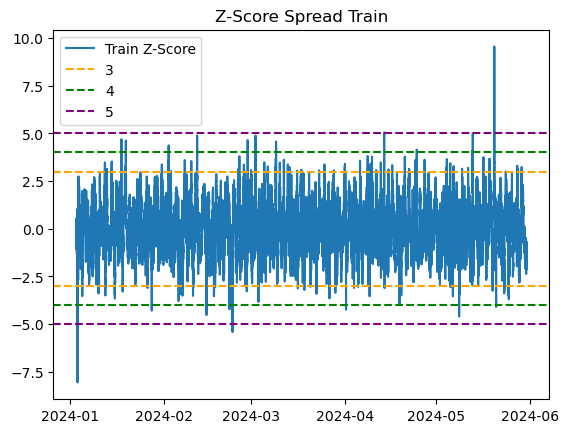

In [7]:
plt.plot(zscore_series_train, label='Train Z-Score')
plt.axhline(3, color='orange', linestyle='--', label='3')
plt.axhline(-3, color='orange', linestyle='--')
plt.axhline(4, color='g', linestyle='--', label='4')
plt.axhline(-4, color='g', linestyle='--',)
plt.axhline(5, color='purple', linestyle='--', label='5')
plt.axhline(-5, color='purple', linestyle='--')
plt.title('Z-Score Spread Train')
plt.legend()

---

* ## Validation set

---

In [8]:

#prices_val = prices.loc['2024-05-01 00:00:00':'2024-05-31 23:55:00'] #May val data
prices_val = prices.loc['2024-06-01 00:00:00':'2024-06-30 23:55:00'] #May val data
#prices_val = prices_out_of_sample.loc['2025-01-01 00:00:00':'2025-02-28 23:55:00'] #January-Feb 2025 val data


#Only use the first month of prices for now
# start_date = pd.to_datetime('2024-01-01 00:00:00')
# end_date = pd.to_datetime('2024-01-31 23:55:00') 

#prices = prices.loc[start_date:end_date] # 2880 rows = 1 month of 5-minute data

#Params for spread calculation
window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!

# Load your precomputed z-score spreads and raw prices as NumPy arrays
sym1_val, sym2_val = prices_val.columns
S1_val = prices_val[sym1_val]
S2_val = prices_val[sym2_val]

print("Computing spread series and beta series...")
# Compute the spread series and beta_series 
spread_series_val, beta_series_val, alpha_series_val = compute_spread_series(S1_val, S2_val, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series_val, rolling_mean_val, rolling_std_val = compute_rolling_zscore(spread_series_val, window_size)

#Drop NaN values from zscore_series
zscore_series_val = zscore_series_val.dropna()

#Esnure prices and beta_series are aligned with zscore_series after dropping NaN values in the zscore_series
prices_val = prices_val.loc[zscore_series_val.index]
beta_series_val = beta_series_val.loc[zscore_series_val.index]


Computing spread series and beta series...


In [9]:
prices_val

,MANAUSDT_2024_5m,SANDUSDT_2024_5m
timestamp,,
2024-06-03 01:15:00,0.4433,0.4378
2024-06-03 01:20:00,0.4458,0.4400
2024-06-03 01:25:00,0.4464,0.4407
2024-06-03 01:30:00,0.4474,0.4424
2024-06-03 01:35:00,0.4468,0.4416
...,...,...
2024-06-29 23:20:00,0.3312,0.3263
2024-06-29 23:35:00,0.3311,0.3261
2024-06-29 23:40:00,0.3307,0.3259


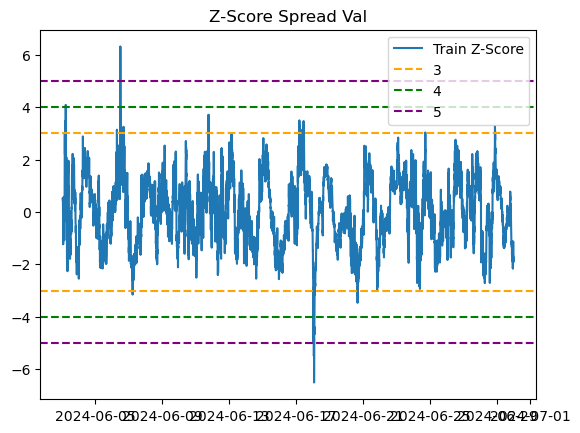

In [10]:
plt.plot(zscore_series_val, label='Train Z-Score')
plt.axhline(3, color='orange', linestyle='--', label='3')
plt.axhline(-3, color='orange', linestyle='--')
plt.axhline(4, color='g', linestyle='--', label='4')
plt.axhline(-4, color='g', linestyle='--',)
plt.axhline(5, color='purple', linestyle='--', label='5')
plt.axhline(-5, color='purple', linestyle='--')
plt.title('Z-Score Spread Val')
plt.legend()

---

* ## Test set

---

In [11]:

#prices_test = prices.loc['2024-06-01 00:00:00':'2024-06-29 23:55:00']
#prices_test = prices.loc['2024-06-01 00:00:00':'2024-06-30 23:55:00']

#prices_test = prices.loc['2024-05-01 00:00:00':'2024-06-30 23:55:00'] #May and June test data

prices_test = prices.loc['2024-07-01 00:00:00':'2024-09-30 23:55:00'] #July to September test data

#Test set is the out-of-sample data
#prices_test = prices_out_of_sample.loc['2025-03-01 00:00:00':'2025-03-31 23:55:00'] #March 2025 test data

#Only use the first month of prices for now
# start_date = pd.to_datetime('2024-01-01 00:00:00')
# end_date = pd.to_datetime('2024-01-31 23:55:00') 

#prices = prices.loc[start_date:end_date] # 2880 rows = 1 month of 5-minute data

#Params for spread calculation
window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!

# Load your precomputed z-score spreads and raw prices as NumPy arrays
sym1_test, sym2_test = prices_test.columns
S1_test = prices_test[sym1_test]
S2_test = prices_test[sym2_test]

print("Computing spread series and beta series...")
# Compute the spread series and beta_series 
spread_series_test, beta_series_test, alpha_series_test = compute_spread_series(S1_test, S2_test, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series_test, rolling_mean_test, rolling_std_test = compute_rolling_zscore(spread_series_test, window_size)

#Drop NaN values from zscore_series
zscore_series_test = zscore_series_test.dropna()

#Esnure prices and beta_series are aligned with zscore_series after dropping NaN values in the zscore_series
prices_test = prices_test.loc[zscore_series_test.index]
beta_series_test = beta_series_test.loc[zscore_series_test.index]


Computing spread series and beta series...


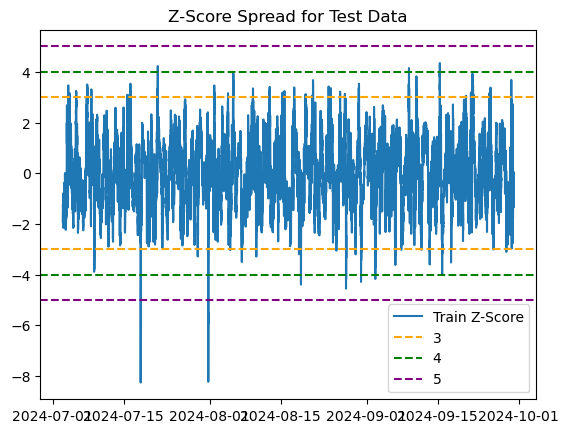

In [12]:
plt.plot(zscore_series_test, label='Train Z-Score')
plt.axhline(3, color='orange', linestyle='--', label='3')
plt.axhline(-3, color='orange', linestyle='--')
plt.axhline(4, color='g', linestyle='--', label='4')
plt.axhline(-4, color='g', linestyle='--',)
plt.axhline(5, color='purple', linestyle='--', label='5')
plt.axhline(-5, color='purple', linestyle='--')
plt.title('Z-Score Spread for Test Data')
plt.legend()

---

# Train agent
---

In [13]:

print("Training DQN agent...")
# Define your discrete threshold pairs: [(entry1, stop1), (entry2, stop2), ...]
entry_stop_pairs = [(1, 2), (2, 3),(3, 4),(4,5)]
# Training parameters
initial_capital = 10_000
tx_cost = 0

online_net, replay_buffer,epoch_loss_history, reward_history,validation_reward_history,training_metrics = train_dqn(
                                                                                        zscore_series_train, 
                                                                                        prices_train, 
                                                                                        beta_series_train,
                                                                                        zscore_series_val,
                                                                                        prices_val,
                                                                                        beta_series_val,
                                                                                        initial_capital,
                                                                                        tx_cost,
                                                                                        entry_stop_pairs, 
                                                                                        num_epochs=220,
                                                                                        batch_size=32,
                                                                                        gamma = 0.99,
                                                                                        lr = 0.001,
                                                                                        epsilon_start = 1,
                                                                                        epsilon_end = 0.01,
                                                                                        epsilon_decay = 0.995,
                                                                                        replay_capacity = 1000,
                                                                                        target_update_freq = 10,
                                                                                        hidden_dim = 64,
                                                                                        tau= 0.01,                                           
                                                                                        )

# Save the trained model
torch.save(online_net.state_dict(), 'dqn_model.pth')


Training DQN agent...
Number of cycles: 651
Epoch 01 | AvgReward: -0.54 | Epsilon: 0.995
Epoch 02 | AvgReward: -0.49 | Epsilon: 0.990
Epoch 03 | AvgReward: -0.50 | Epsilon: 0.985
Epoch 04 | AvgReward: -0.46 | Epsilon: 0.980
Epoch 05 | AvgReward: -0.51 | Epsilon: 0.975
Epoch 06 | AvgReward: -0.51 | Epsilon: 0.970
Epoch 07 | AvgReward: -0.46 | Epsilon: 0.966
Epoch 08 | AvgReward: -0.48 | Epsilon: 0.961
Epoch 09 | AvgReward: -0.45 | Epsilon: 0.956
Epoch 10 | AvgReward: -0.48 | Epsilon: 0.951
Epoch 11 | AvgReward: -0.44 | Epsilon: 0.946
Epoch 12 | AvgReward: -0.50 | Epsilon: 0.942
Epoch 13 | AvgReward: -0.44 | Epsilon: 0.937
Epoch 14 | AvgReward: -0.51 | Epsilon: 0.932
Epoch 15 | AvgReward: -0.48 | Epsilon: 0.928
Epoch 16 | AvgReward: -0.49 | Epsilon: 0.923
Epoch 17 | AvgReward: -0.43 | Epsilon: 0.918
Epoch 18 | AvgReward: -0.44 | Epsilon: 0.914
Epoch 19 | AvgReward: -0.44 | Epsilon: 0.909
Epoch 20 | AvgReward: -0.38 | Epsilon: 0.905
Epoch 21 | AvgReward: -0.45 | Epsilon: 0.900
Epoch 22 | 

In [14]:
# n_trials = 10
# num_epochs = 220

# best_reward, best_params = optimize_hyperparameters(
#     zscore_series_train, prices_train, beta_series_train,
#     zscore_series_val,   prices_val,   beta_series_val,
#     initial_capital, tx_cost,
#     entry_stop_pairs,
#     n_trials,
#     num_epochs
# )

In [15]:
# lr_best, batch_size_best, hidden_dim_best, gamma_best, epsilon_decay_best, tau_best = best_params.values()

# print(f"Best reward: {best_reward}")
# print(f"Best hyperparameters: {best_params.values()}")
# # Train the DQN agent with the best hyperparameters

# #lr_best, batch_size_best, hidden_dim_best, gamma_best, epsilon_decay_best, tau_best = 0.00010366806196026195, 16, 32, 0.9811910981039401, 0.9906752554940417, 0.007164004897848127



In [16]:

# online_net, replay_buffer,epoch_loss_history, reward_history,validation_reward_history,training_metrics = train_dqn(
#                                                                                         zscore_series_train, 
#                                                                                         prices_train, 
#                                                                                         beta_series_train,
#                                                                                         zscore_series_val,
#                                                                                         prices_val,
#                                                                                         beta_series_val,
#                                                                                         initial_capital,
#                                                                                         tx_cost,
#                                                                                         entry_stop_pairs, 
#                                                                                         num_epochs=num_epochs,
#                                                                                         batch_size=batch_size_best,
#                                                                                         gamma = gamma_best,
#                                                                                         lr = lr_best,
#                                                                                         epsilon_start = 1,
#                                                                                         epsilon_end = 0.01,
#                                                                                         epsilon_decay = epsilon_decay_best,
#                                                                                         replay_capacity = 1000,
#                                                                                         target_update_freq = 10,
#                                                                                         hidden_dim = hidden_dim_best,
#                                                                                         tau= tau_best,                                           
#                                                                                         )

# # Save the trained model
# torch.save(online_net.state_dict(), 'dqn_model.pth')

In [17]:
# training_metrics_temp = training_metrics.copy()

In [18]:
entry_stop_pairs_extended = [(1, 2), (2, 3),(3, 4),(4,5),(5,6),(6,7),(7,8),(8,9),(9,10)]

# Best thresholds
---

In [19]:
# env = PairsTradingEnv(zscore_series_train, prices_train, beta_series_train, initial_capital, tx_cost, entry_stop_pairs_extended, eval_mode=True) #keep eval_mode=True so no cylces are removed
# best_pairs_train = env.find_best_thresholds()
# spread_cycles_train = env.spread_cycles

# #best_pairs_train = find_best_thresholds(entry_stop_pairs,zscore_series_train,prices_train,beta_series_train)

# # Suppose best_pairs is your list of length N containing either (e,s) or None
# counts = Counter(best_pairs_train)   # Now counts[None] is how many cycles had no winning pair
# total  = len(best_pairs_train)

# # Convert raw counts to percentages
# pairs    = list(counts.keys())
# percent_train  = [counts[p] / total * 100 for p in pairs]

# # Turn None → a string label
# labels = [
#     "no winner" if p is None else f"{p[0]},{p[1]}"
#     for p in pairs
# ]

# zip_object = zip(labels, percent_train)

# print("Percentage Counts")
# print("---------------------")
# print(percent_train)

# print("Numerical counts")
# print("---------------------")
# print([counts[p] for p in pairs])


# # Plot
# plt.figure(figsize=(8,6))
# bars = plt.bar(range(len(labels)), percent_train, tick_label=labels)
# plt.ylabel("% of cycles")
# plt.xlabel("(entry, stop) pair")

# #Add value labels on top of the bars
# for bar in bars:
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.1f}%", ha='center', va='bottom')
# plt.xticks(rotation=45)
# plt.title("Best Entry–Stop Pair Coverage (Training set)")

# plt.tight_layout()





In [20]:
# env_val_best = PairsTradingEnv(zscore_series_val, prices_val, beta_series_val, initial_capital, tx_cost, entry_stop_pairs_extended, eval_mode=True)
# best_pairs_val = env_val_best.find_best_thresholds()
# spread_cycles_val = env_val_best.spread_cycles


# # Suppose best_pairs is your list of length N containing either (e,s) or None
# counts = Counter(best_pairs_val)   # Now counts[None] is how many cycles had no winning pair
# total  = len(best_pairs_val)

# # Convert raw counts to percentages
# pairs    = list(counts.keys())
# percent_val  = [counts[p] / total * 100 for p in pairs]

# # Turn None → a string label
# labels = [
#     "no winner" if p is None else f"{p[0]},{p[1]}"
#     for p in pairs
# ]

# print("Percentage Counts")
# print("---------------------")
# print(percent_val)


# print("Numerical counts")
# print("---------------------")
# print([counts[p] for p in pairs])



# # Plot
# plt.figure(figsize=(8,6))
# bars = plt.bar(range(len(labels)), percent_val, tick_label=labels)

# #Add percentage values on top of the bars
# for bar, percent in zip(bars, percent_val):
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f"{percent:.1f}%", ha='center', va='bottom')


# plt.ylabel("% of cycles")
# plt.xlabel("(entry, stop) pair")
# plt.title("Best Entry–Stop Pair Coverage (Validation set))")

In [21]:
# env_test_best = PairsTradingEnv(zscore_series_test, prices_test, beta_series_test, initial_capital, tx_cost, entry_stop_pairs_extended, eval_mode=True)
# best_pairs_test = env_test_best.find_best_thresholds()
# spread_cycles_test = env_test_best.spread_cycles


# # Suppose best_pairs is your list of length N containing either (e,s) or None
# counts = Counter(best_pairs_test)   # Now counts[None] is how many cycles had no winning pair
# total  = len(best_pairs_test)

# # Convert raw counts to percentages
# pairs    = list(counts.keys())
# percent_test  = [counts[p] / total * 100 for p in pairs]

# # Turn None → a string label
# labels = [
#     "no winner" if p is None else f"{p[0]},{p[1]}"
#     for p in pairs
# ]

# print("Percentage Counts")
# print("---------------------")
# print(percent_test)


# print("Numerical counts")
# print("---------------------")
# print([counts[p] for p in pairs])



# # Plot
# plt.figure(figsize=(8,6))
# bars = plt.bar(range(len(labels)), percent_test, tick_label=labels)
# plt.ylabel("% of cycles")
# plt.xlabel("(entry, stop) pair")

# #Add percentage text on top of each bar
# for bar, percent in zip(bars, percent_test):
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f"{percent:.1f}%", ha='center', va='bottom')
    
# plt.title("Best Entry–Stop Pair Coverage (Test set)")
# plt.tight_layout()




In [22]:
# plt.plot(zscore_series_train.iloc[0:420], color = 'grey', label='Z-Score Series')
# plt.plot(spread_cycles_train[0], color = 'r', label='Cycle 1')
# plt.plot(spread_cycles_train[1], color = 'b' , label='Cycle 2')
# plt.plot(spread_cycles_train[2], color = 'orange' , label='Cycle 3')
# plt.plot(spread_cycles_train[3], color = 'purple' , label='Cycle 4')
# plt.plot(spread_cycles_train[4], color = 'pink' , label='Cycle 5')
# plt.axhline(0, color = 'black', linestyle='--')
# plt.axhline(1, color = 'green', linestyle='--')
# plt.axhline(-1, color = 'green', linestyle='--')
# plt.legend(loc='lower left')
# plt.title('Z-Score Series with Cycles illustration (for training set)')

# Training performance
---

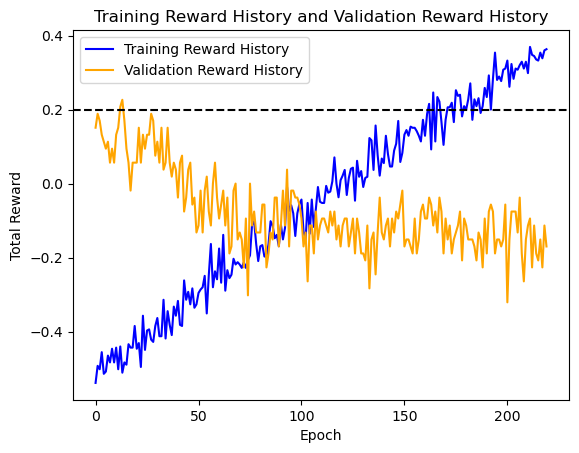

In [23]:
plt.plot(reward_history, color = 'blue', label = 'Training Reward History')
plt.plot(validation_reward_history, color = 'orange', label = 'Validation Reward History')
plt.title('Training Reward History and Validation Reward History')
plt.axhline(0.2, color = 'black', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

(array([15., 22., 19., 21., 21., 23., 24., 25., 24., 26.]),
 array([-0.53846154, -0.44769231, -0.35692308, -0.26615385, -0.17538462,
        -0.08461538,  0.00615385,  0.09692308,  0.18769231,  0.27846154,
         0.36923077]),
 <BarContainer object of 10 artists>)

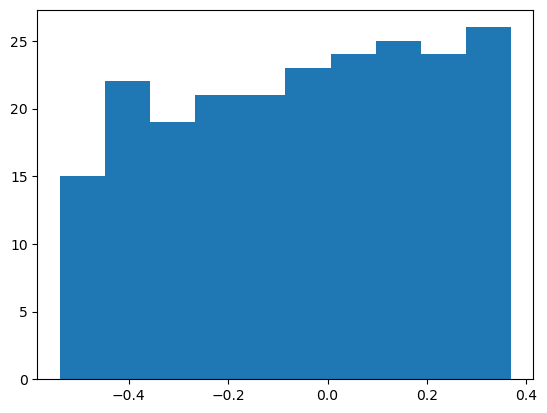

In [24]:
plt.hist(reward_history)

In [25]:
# def exponential_smooth(values, weight=0.9):
#     smoothed = [values[0]]
#     for val in values[1:]:
#         smoothed.append(weight * smoothed[-1] + (1 - weight) * val)
#     return smoothed

# smoothed_val_reward_history = exponential_smooth(validation_reward_history, weight=0.9)
# plt.plot(smoothed_val_reward_history, color='orange', label='Smoothed Validation Reward History')

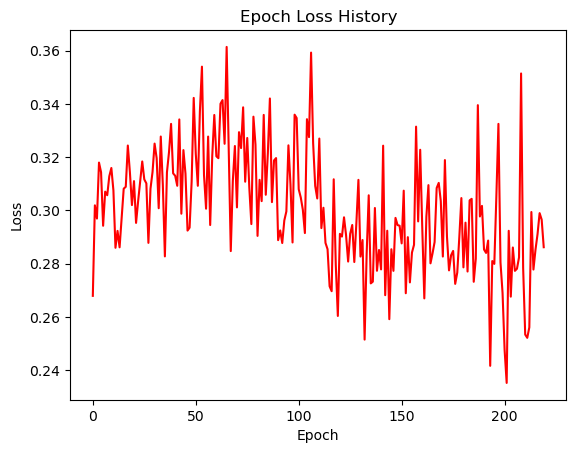

In [26]:
plt.plot(epoch_loss_history, color = 'red')
plt.title('Epoch Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [27]:
win_rates = training_metrics['win_rates']
loss_rates = training_metrics['loss_rates']
forced_rates = training_metrics['forced_rates']
none_rates = training_metrics['no_trade_rates']

print("Final win rates: ", win_rates[-1])
print("Final loss rates: ", loss_rates[-1])
print("Final forced rates: ", forced_rates[-1])
print("Final none rates: ", none_rates[-1])

training_metrics = {'win_rate': win_rates[-1],
                                 'loss_rate': loss_rates[-1],
                                 'forced_rate': forced_rates[-1],
                                 'none_rate': none_rates[-1]}

# plt.plot(win_rates, color = 'green',label = 'Win Rates')
# plt.plot(loss_rates, color = 'red', label = 'Loss Rates')
# #plt.plot(forced_rates, color = 'orange', label = 'Forced Rates')
# plt.plot(none_rates, color = 'blue', label = 'None Rates')

# plt.legend()
# plt.title('Training Metrics')
# plt.xlabel('Epoch') 
training_metrics

Final win rates:  0.6815384615384615
Final loss rates:  0.09538461538461539
Final forced rates:  0.0
Final none rates:  0.2230769230769231


{'win_rate': 0.6815384615384615,
 'loss_rate': 0.09538461538461539,
 'forced_rate': 0.0,
 'none_rate': 0.2230769230769231}

In [28]:
training_metrics

{'win_rate': 0.6815384615384615,
 'loss_rate': 0.09538461538461539,
 'forced_rate': 0.0,
 'none_rate': 0.2230769230769231}

# Hyper-Parameter Tuning
---

In [29]:
# best_trial, study = optimize_hyperparameters(
#     zscore_series_train, prices_train, beta_series_train,
#     zscore_series_val,   prices_val,   beta_series_val,
#     initial_capital, tx_cost,
#     entry_stop_pairs,
#     n_trials=50
# )

# Evaluate
---

In [30]:
#Recreate the model and load the saved state_dict
#online_net_trained = DQN(input_dim=6, output_dim=len(entry_stop_pairs), hidden_dim=hidden_dim_best)# Load the saved state_dict into the model
online_net_trained = DQN(input_dim=7, output_dim=len(entry_stop_pairs), hidden_dim=64)# Load the saved state_dict into the model
online_net_trained.load_state_dict(torch.load('dqn_model.pth'))



/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_57834/2195740669.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  online_net_trained.load_state_dict(torch.load

<All keys matched successfully>

In [156]:
tx_cost = 0.000

#define test environment
env_test = PairsTradingEnv(zscore_series_test, prices_test, beta_series_test, initial_capital, tx_cost, entry_stop_pairs, eval_mode=True)

#TEST SET
test_rewards,trade_profits,actions,episodes,test_metrics = evaluate_dqn(
    env_test,
    online_net_trained,
    entry_stop_pairs,
)
print(test_metrics)

#TRAINING SET

# test_rewards,trade_profits,actions,episodes,test_metrics = evaluate_dqn(
#     online_net_trained,
#     zscore_series_train,
#     prices_train,
#     beta_series_train,
#     initial_capital,
#     tx_cost,
#     entry_stop_pairs,
# )
# print(test_metrics)

#VALIDATION SET

# test_rewards,trade_profits,actions,episodes,test_metrics = evaluate_dqn(
#     online_net_trained,
#     zscore_series_val,
#     prices_val,
#     beta_series_val,
#     initial_capital,
#     tx_cost,
#     entry_stop_pairs,
# )
# print(test_metrics)



{'avg_reward': -0.12462908011869436, 'win_rate': 0.4362017804154303, 'loss_rate': 0.27596439169139464, 'forced_rate': 0.002967359050445104, 'no_trade_rate': 0.28486646884273}


In [157]:
episodes[0]['exit_meta']['time']

Timestamp('2024-07-03 19:45:00')

In [158]:
actions_profits_list = zip(actions,trade_profits)
actions_profits_df = pd.DataFrame(actions_profits_list, columns=['Actions', 'Trade Profits'])

#Show all rows
# pd.set_option('display.max_rows', None)=
# pd.set_option('display.max_columns', None)

# actions_profits_df_zeros = actions_profits_df[actions_profits_df['Trade Profits'] > 0]
#actions_profits_df_zeros

actions_profits_df_three_four = actions_profits_df[actions_profits_df['Actions'] == (3, 4)]
actions_profits_df_three_four.head(50)

,Actions,Trade Profits
1,"(3, 4)",0.000000
11,"(3, 4)",0.000000
23,"(3, 4)",0.000000
27,"(3, 4)",0.000000
40,"(3, 4)",0.000000
41,"(3, 4)",0.000000
48,"(3, 4)",0.000000
61,"(3, 4)",0.000000
83,"(3, 4)",0.000000
86,"(3, 4)",0.000000


Action (1, 2): 56.38%
Action (2, 3): 31.75%
Action (3, 4): 11.28%
Action (4, 5): 0.59%


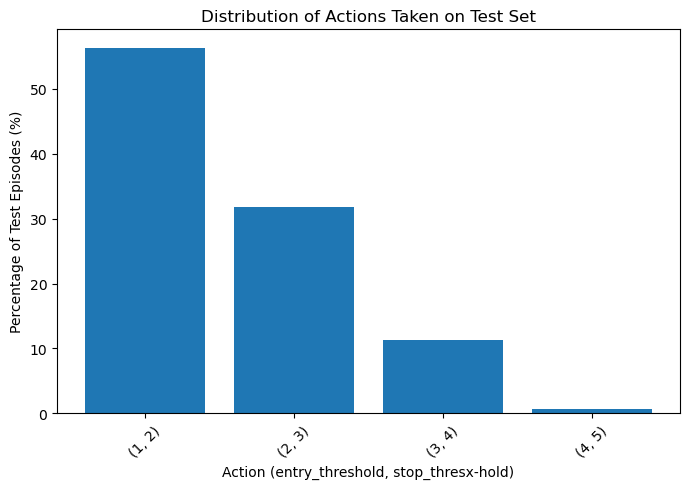

In [159]:
#Count number of each action in the actions list
from collections import Counter

# 1. Count how many times each action appears
counts = Counter(actions)
total = len(actions)

# 2. Compute percentages
actions_sorted = sorted(counts.keys())
percentages = [counts[a] / total * 100 for a in actions_sorted]

actions_percentages_zip = zip(actions_sorted, percentages)

# 3. Print the results
for action, percentage in actions_percentages_zip:
    print(f"Action {action}: {percentage:.2f}%")

# 4. Plot the distribution
plt.figure(figsize=(7, 5))
plt.bar(range(len(actions_sorted)), percentages)
plt.xticks(range(len(actions_sorted)), [f"{a}" for a in actions_sorted], rotation=45)
plt.ylabel("Percentage of Test Episodes (%)")
plt.xlabel("Action (entry_threshold, stop_thresx-hold)")
plt.title("Distribution of Actions Taken on Test Set")
plt.tight_layout()
plt.show()

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   1.,   0.,   1.,   1.,   5.,   3.,
          3.,  11.,  12.,  24.,   9.,  10.,   6.,   7.,   7., 100.,   6.,
         10.,  15.,  19.,  23.,  18.,  15.,  10.,   7.,   3.,   4.,   3.,
          1.,   0.,   0.,   0.,   0.,   1.]),
 array([-1.09829222e+02, -1.06288237e+02, -1.02747253e+02, -9.92062677e+01,
        -9.56652829e+01, -9.21242980e+01, -8.85833132e+01, -8.50423284e+01,
        -8.15013435e+01, -7.79603587e+01, -7.44193739e+01, -7.08783890e+01,
        -6.73374042e+01, -6.37964194e+01, -6.02554345e+01, -5.67144497e+01,
        -5.31734649e+01, -4.96324800e+01, -4.60914952e+01, -4.25505104e+01,
        -3.90095255e+01, -3.54685407e+01, -3.19275559e+01, -2.83865710e+01,
        -2.48455862e+01, -2.13046014e+01, -1.77636165e+01, -1.42226317e+01,
        -1.06816469e+01, -7.14066204e+00, -3.59967721e+00, -5.86923734e-02,
         3.48229246e+00,  7.02327729e+00,  1.05642

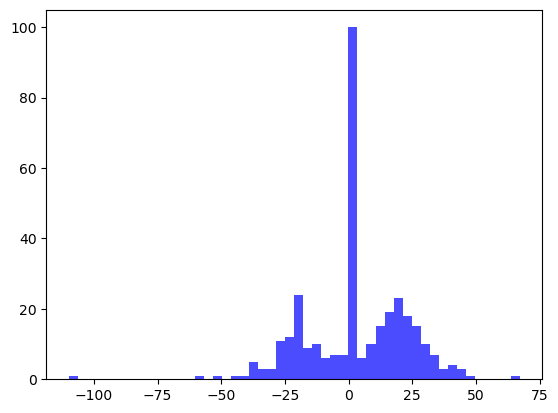

In [160]:
plt.hist(trade_profits, bins=50, color='blue', alpha=0.7)

In [161]:
actual_trade_profits_agent = [profit for profit in trade_profits if profit != 0]
len(actual_trade_profits_agent)

240

In [162]:
actual_trade_profits_agent

[-2.1853278319050737,
 17.10970504722662,
 -26.893877189816152,
 -35.56284295081598,
 9.06075936136142,
 -14.802106752580698,
 -25.63833419286224,
 -59.004935699828934,
 17.931659645498954,
 44.37701168031319,
 29.712579968693117,
 -25.895151696269707,
 24.232099574966224,
 -27.00607835238923,
 22.58897994394921,
 -31.125472551281717,
 24.9872131794355,
 -8.81405838749834,
 29.53750532021595,
 33.950005879027515,
 27.979085842634824,
 28.48837004304076,
 -51.864246762526044,
 -21.102660534958936,
 23.099570302280718,
 18.93096050346667,
 18.279097753211587,
 19.283564697476436,
 -19.465197124324423,
 15.562157502886176,
 -23.98041940130311,
 17.75001495959663,
 -18.962508790796317,
 -38.94406760707788,
 33.66195931534903,
 21.815942147287412,
 13.440288167838915,
 -14.156591294665155,
 -26.948912997864397,
 -12.538558003277121,
 23.25440255048633,
 20.467258420062873,
 -15.233791588607978,
 20.703423881944424,
 9.070640891108225,
 -26.68746162579866,
 -23.589769463064414,
 42.232509898

Final returns:  8.091222746538048 %


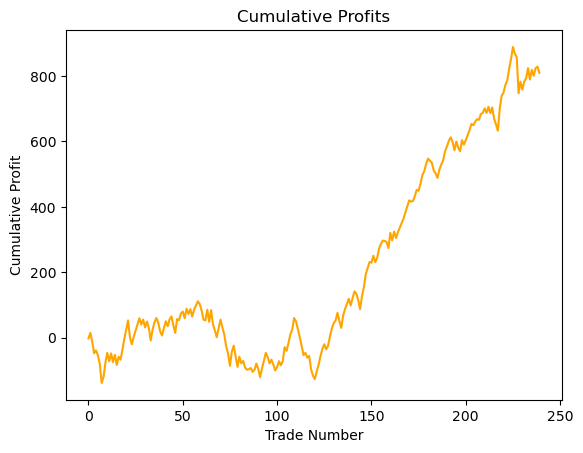

In [163]:
trade_profits_cumulative_agent = np.cumsum(actual_trade_profits_agent)
final_return_test_set = (trade_profits_cumulative_agent[-1]/initial_capital) * 100
print("Final returns: ", final_return_test_set, "%")
plt.plot(trade_profits_cumulative_agent, color='orange')
plt.title('Cumulative Profits')
plt.xlabel('Trade Number')
plt.ylabel('Cumulative Profit')
plt.show()

In [170]:
risk_free_rate = 0.0  # Assuming no risk-free rate for simplicity
sharpe_ratio_agent = compute_sharpe_ratio(initial_capital,actual_trade_profits_agent,risk_free_rate)
print("Sharpe Ratio No agent: ", sharpe_ratio_agent)

Sharpe Ratio No agent:  0.1413196040587994


In [166]:
#Extract exit times from episodes

agent_trade_exit_times = []

for episode in episodes:

    if tx_cost == 0:   

        if episode['exit_meta'] is not None and episode['exit_meta']['exit_type'] != 'forced_exit':
            exit_time = episode['exit_meta']['time']
            agent_trade_exit_times.append(exit_time)
    else:
        if episode['exit_meta'] is not None:
            exit_time = episode['exit_meta']['time']
            agent_trade_exit_times.append(exit_time)


print(len(agent_trade_exit_times))


cumulative_profit_series_agent = pd.Series(trade_profits_cumulative_agent, index=agent_trade_exit_times)


cumulative_profit_series_agent = cumulative_profit_series_agent.reindex(prices_test.index, method='ffill').fillna(0)
cumulative_profit_series_agent

240


timestamp
2024-07-03 00:00:00      0.000000
2024-07-03 00:05:00      0.000000
2024-07-03 00:10:00      0.000000
2024-07-03 00:15:00      0.000000
2024-07-03 00:20:00      0.000000
                          ...    
2024-09-29 23:35:00    809.122275
2024-09-29 23:40:00    809.122275
2024-09-29 23:45:00    809.122275
2024-09-29 23:50:00    809.122275
2024-09-29 23:55:00    809.122275
Length: 25621, dtype: float64

Sharpe Ratio No agent for entry: 1, stop loss: 2 is:  0.041241840866495086
Number of trades:  338
Percentage_Return:  3.190372429367433 %


/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_57834/3675893452.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Percentage_Return: ", (cumulative_profit_series_no_agent[-1] / initial_capital) * 100,"%")


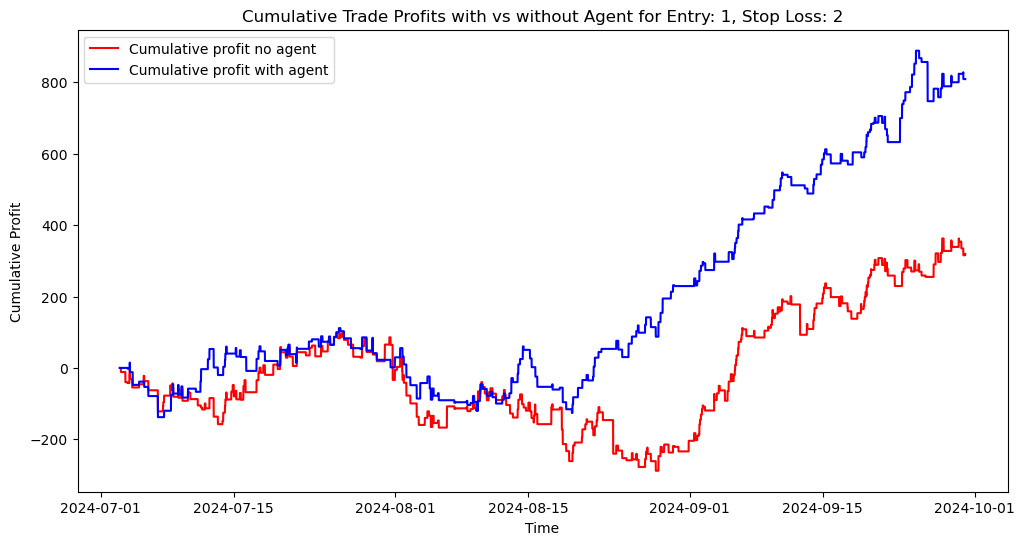

Sharpe Ratio No agent for entry: 2, stop loss: 3 is:  0.13873452535599887
Number of trades:  149
Percentage_Return:  6.567326245546775 %


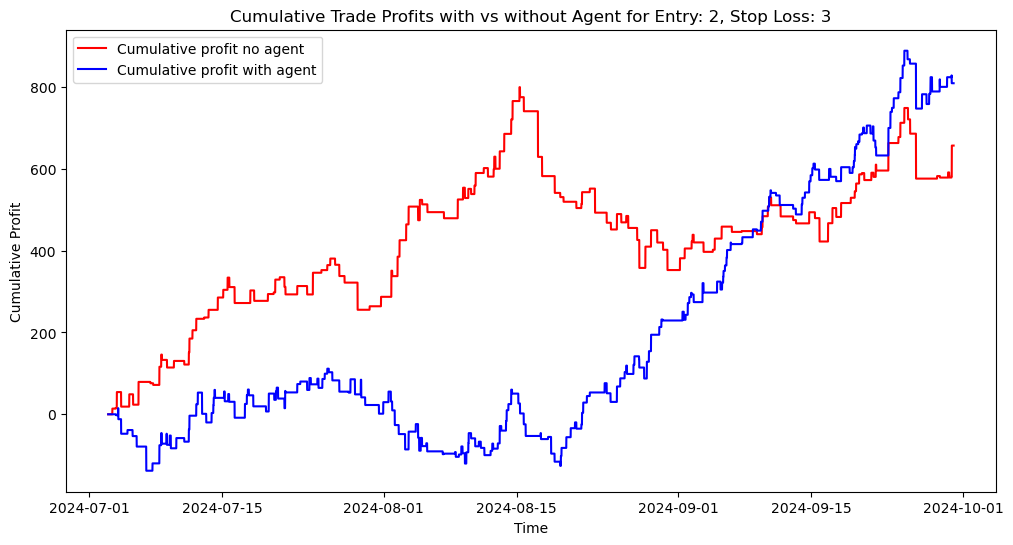

Sharpe Ratio No agent for entry: 3, stop loss: 4 is:  0.26391779325762904
Number of trades:  51
Percentage_Return:  4.752517446850754 %


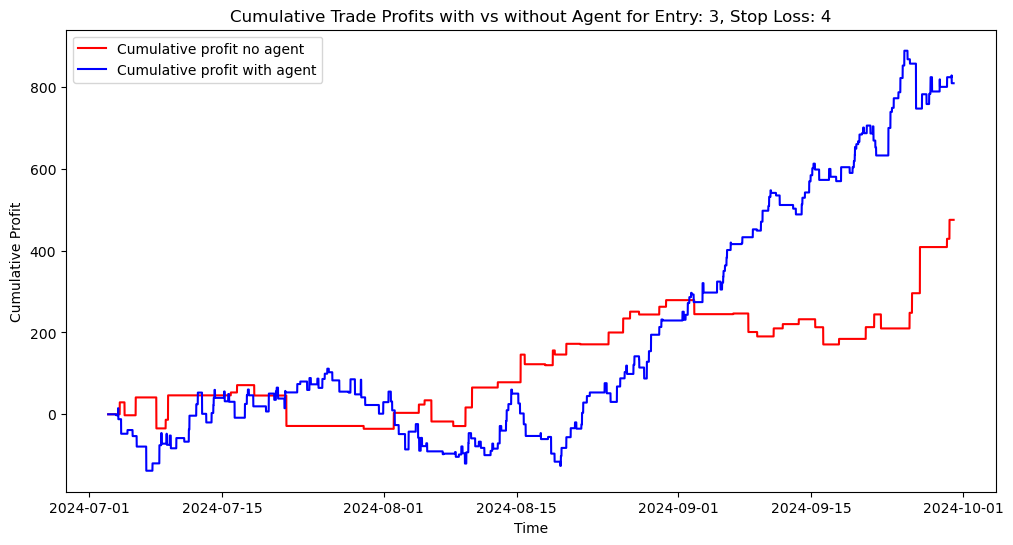

Sharpe Ratio No agent for entry: 4, stop loss: 5 is:  0.08902811843665209
Number of trades:  8
Percentage_Return:  0.2897754513975997 %


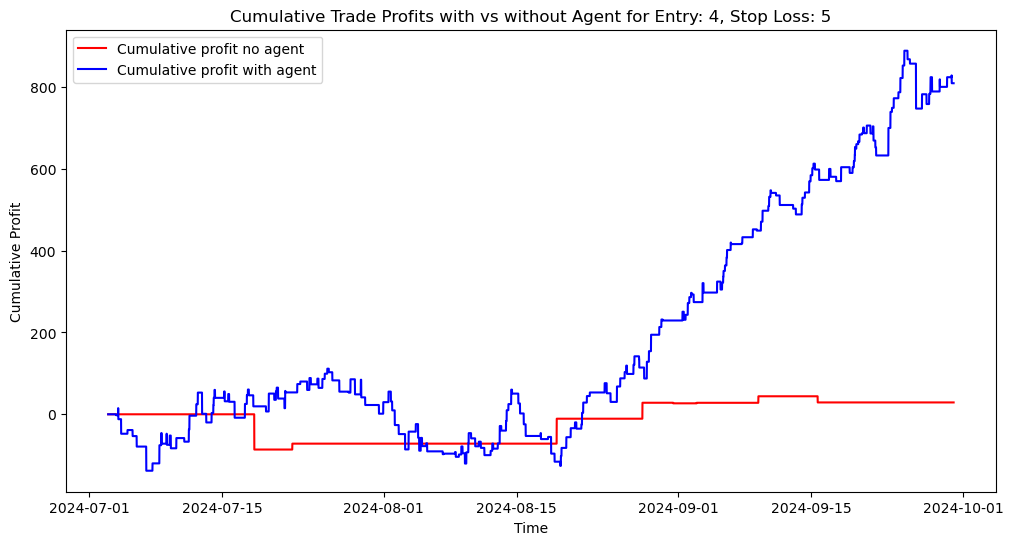

In [171]:

exit_threshold = 0
#tx_cost = 0.00025

#entry_stop_pairs = [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]

for entry_stop_pair in entry_stop_pairs:
    entry_threshold, stop_loss_threshold = entry_stop_pair
    
    #TEST DATA
    #----------
    positions, trade_entries, trade_exits = backtest_pair_rolling(S1_test,S2_test,zscore_series_test, entry_threshold, exit_threshold, stop_loss_threshold)
    trade_profits_no_agent, net_trade_profits_S1_no_agent, net_trade_profits_S2_no_agent,cumulative_profit_series_no_agent, entry_times_no_agent, exit_times_no_agent = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series_test, tx_cost)
    
    share_ratio_no_agent = compute_sharpe_ratio(initial_capital,trade_profits_no_agent,risk_free_rate)

    print(f"Sharpe Ratio No agent for entry: {entry_threshold}, stop loss: {stop_loss_threshold} is: ", share_ratio_no_agent)
    # #TRAIN DATA
    # #----------
    # positions, trade_entries, trade_exits = backtest_pair_rolling(S1_train,S2_train,zscore_series_train, entry_threshold, exit_threshold, stop_loss_threshold)
    # trade_profits_no_agent, net_trade_profits_S1_no_agent, net_trade_profits_S2_no_agent,cumulative_profit_series_no_agent, entry_times_no_agent, exit_times_no_agent = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series_train, tx_cost)

    #VAL DATA
    #----------
    # positions, trade_entries, trade_exits = backtest_pair_rolling(S1_val,S2_val,zscore_series_val, entry_threshold, exit_threshold, stop_loss_threshold)
    # trade_profits_no_agent, net_trade_profits_S1_no_agent, net_trade_profits_S2_no_agent,cumulative_profit_series_no_agent, entry_times_no_agent, exit_times_no_agent = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series_val, tx_cost)

    #print(trade_profits_no_agent)
    cumulative_profit_series_no_agent_indexed = cumulative_profit_series_no_agent.reindex(prices_test.index, method='ffill').fillna(0)
    print("Number of trades: ", len(trade_profits_no_agent))

    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_profit_series_no_agent_indexed, color = 'red', label = 'Cumulative profit no agent') #Cumulative profits without agent
    plt.plot(cumulative_profit_series_agent, color = 'blue', label = 'Cumulative profit with agent') #Cumulative profits with agent
    print("Percentage_Return: ", (cumulative_profit_series_no_agent[-1] / initial_capital) * 100,"%")
    plt.title(f'Cumulative Trade Profits with vs without Agent for Entry: {entry_threshold}, Stop Loss: {stop_loss_threshold}')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Profit')
    plt.legend()
    plt.show()

# Case study
---

In [168]:
episodes[2]['cycle_idx']

3

In [39]:
env_test

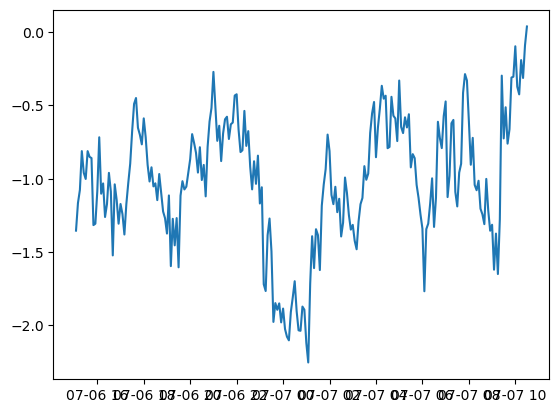

In [92]:
cycle_forced = env_test.spread_cycles[10]

plt.plot(cycle_forced, label='Z-Score Series')

In [91]:
cycle_forced

timestamp
2024-09-29 12:20:00    2.280461
2024-09-29 12:25:00    2.305621
2024-09-29 12:30:00    2.882682
2024-09-29 12:35:00    3.360871
2024-09-29 12:40:00    3.679627
2024-09-29 12:45:00    2.669260
2024-09-29 12:50:00    2.902889
2024-09-29 12:55:00    2.810802
2024-09-29 13:00:00    2.398639
2024-09-29 13:05:00    1.483267
2024-09-29 13:10:00    0.802336
2024-09-29 13:15:00    0.369338
2024-09-29 13:20:00   -1.022253
dtype: float64

In [84]:
for episode in episodes:
    if episode['exit_meta'] is not None:
        exit_type = episode['exit_meta']['exit_type']
        print(f"Exit Type: {exit_type}")
        

Exit Type: loss
Exit Type: win
Exit Type: loss
Exit Type: loss
Exit Type: loss
Exit Type: loss
Exit Type: loss
Exit Type: loss
Exit Type: loss
Exit Type: win
Exit Type: win
Exit Type: loss
Exit Type: win
Exit Type: loss
Exit Type: win
Exit Type: loss
Exit Type: win
Exit Type: win
Exit Type: win
Exit Type: win
Exit Type: win
Exit Type: win
Exit Type: loss
Exit Type: loss
Exit Type: win
Exit Type: win
Exit Type: win
Exit Type: win
Exit Type: loss
Exit Type: win
Exit Type: loss
Exit Type: win
Exit Type: loss
Exit Type: loss
Exit Type: win
Exit Type: win
Exit Type: win
Exit Type: loss
Exit Type: loss
Exit Type: loss
Exit Type: win
Exit Type: win
Exit Type: loss
Exit Type: win
Exit Type: win
Exit Type: loss
Exit Type: win
Exit Type: win
Exit Type: loss
Exit Type: win
Exit Type: win
Exit Type: win
Exit Type: win
Exit Type: loss
Exit Type: win
Exit Type: loss
Exit Type: win
Exit Type: win
Exit Type: win
Exit Type: loss
Exit Type: loss
Exit Type: win
Exit Type: win
Exit Type: win
Exit Type: lo

In [95]:
trade_profits[333]

0.0

In [94]:
episodes[333]

{'cycle_idx': 334,
 'entry_meta': {'time': Timestamp('2024-09-29 13:20:00'),
  'S1': 0.3223,
  'S2': 0.289,
  'z': -1.0222534891919761,
  'position': 1},
 'exit_meta': {'time': Timestamp('2024-09-29 13:20:00'),
  'S1': 0.3223,
  'S2': 0.289,
  'z': -1.0222534891919761,
  'exit_type': 'forced_exit'},
 'entry_threshold': 1,
 'stop_threshold': 2}

In [41]:
len(env_test.spread_cycles)

338

In [42]:
episodes[11]

{'cycle_idx': 12,
 'entry_meta': None,
 'exit_meta': None,
 'entry_threshold': 3,
 'stop_threshold': 4}

In [43]:
#Analyze properties of cycles that were lost:

chosen_vs_best_pairs = []

for episode in (episodes):


    if episode['exit_meta'] != None and episode['exit_meta']['exit_type'] == 'loss':
        
        
        #Get the index of the traded cycle
        episode_cycle_index = episode['cycle_idx'] #The spread cycle that was traded in this index

        #Get the threshold chosen for this cycle
        chosen_entry, chosen_stop = episode['entry_threshold'], episode['stop_threshold'] #The entry and stop thresholds chosen for this cycle

        chosen_entry_stop_pair = (chosen_entry, chosen_stop)

        #Get the best threshold pair for this cycle
        best_entry_stop_pair = env_test.best_pairs[episode_cycle_index]


        chosen_vs_best_pairs.append((chosen_entry_stop_pair, env_test.best_pairs[episode_cycle_index]))

       

        # cycle = env_test.spread_cycles[episode_cycle_index] #The actual cycle

print("Chosen vs Best Pairs for Loss Cycles")
print("------------------------------")
chosen_vs_best_pairs



Chosen vs Best Pairs for Loss Cycles
------------------------------


[((1, 2), (2, 3)),
 ((1, 2), (3, 4)),
 ((2, 3), (3, 4)),
 ((1, 2), (2, 3)),
 ((1, 2), (3, 4)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (3, 4)),
 ((1, 2), (3, 4)),
 ((1, 2), (3, 4)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (3, 4)),
 ((2, 3), (3, 4)),
 ((1, 2), (2, 3)),
 ((1, 2), None),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (4, 5)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (3, 4)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (3, 4)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((2, 3), (3, 4)),
 ((1, 2), (2, 3)),
 ((1, 2), (3, 4)),
 ((1, 2), (3, 4)),
 ((1, 2), (3, 4)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((2, 3), (3, 4)),
 ((2, 3), (3, 4)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((2, 3), (3, 

In [44]:
one_two_counter = 0
two_three_counter = 0
three_four_counter = 0
four_five_counter = 0   

for chosen_pair , best_pair in chosen_vs_best_pairs:

    if chosen_pair == (1, 2) and best_pair == (1, 2):
        one_two_counter += 1
    elif chosen_pair == (2, 3) and best_pair == (2, 3):
        two_three_counter += 1
    elif chosen_pair == (3, 4) and best_pair == (3, 4):
        three_four_counter += 1
    elif chosen_pair == (4, 5) and best_pair == (4, 5):
        four_five_counter += 1

print("------------------------------")
print(f"Chosen (1, 2) vs Best (1, 2): {one_two_counter}")
print(f"Chosen (2, 3) vs Best (2, 3): {two_three_counter}")
print(f"Chosen (3, 4) vs Best (3, 4): {three_four_counter}")
print(f"Chosen (4, 5) vs Best (4, 5): {four_five_counter}")
    


------------------------------
Chosen (1, 2) vs Best (1, 2): 0
Chosen (2, 3) vs Best (2, 3): 0
Chosen (3, 4) vs Best (3, 4): 0
Chosen (4, 5) vs Best (4, 5): 0


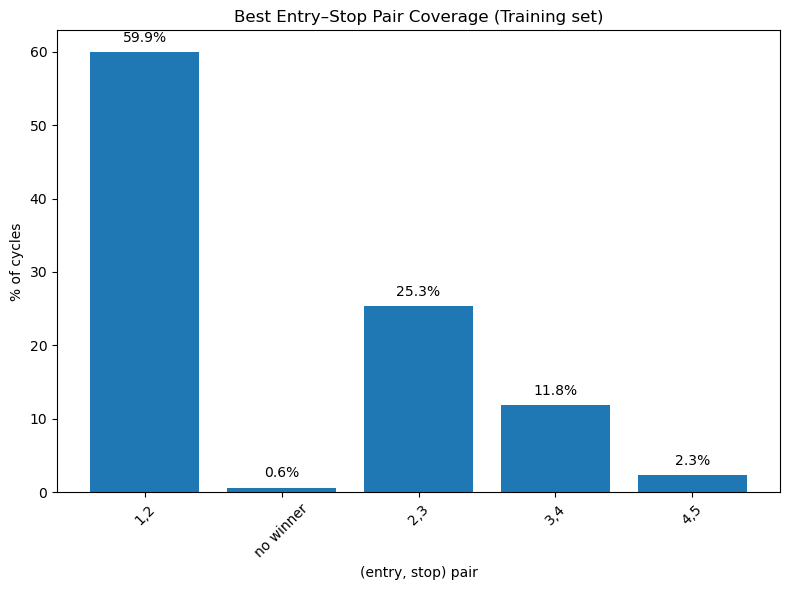

In [45]:
#Compare distirbution of best_pairs in training set and testing set
training_env = PairsTradingEnv(
        zscore_series_train, prices_train, beta_series_train,
        initial_capital, tx_cost,
        entry_stop_pairs,
        eval_mode=False) #Set eval_mode to False for training

#Plot distribution of best pairs in training set
training_best_pairs = training_env.best_pairs
training_counts = Counter(training_best_pairs)
# Convert raw counts to percentages
training_pairs = list(training_counts.keys())
training_percentages = [training_counts[p] / len(training_best_pairs) * 100 for p in training_pairs]
# Turn None → a string label
training_labels = [
    "no winner" if p is None else f"{p[0]},{p[1]}"
    for p in training_pairs
]
# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(range(len(training_labels)), training_percentages, tick_label=training_labels)
plt.ylabel("% of cycles")
plt.xlabel("(entry, stop) pair")
# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.1f}%", ha='center', va='bottom')
plt.xticks(rotation=45)
plt.title("Best Entry–Stop Pair Coverage (Training set)")
plt.tight_layout()


In [46]:
training_best_pairs

[(1, 2),
 (1, 2),
 None,
 (2, 3),
 (2, 3),
 (2, 3),
 (1, 2),
 (3, 4),
 (1, 2),
 (2, 3),
 (1, 2),
 (2, 3),
 (1, 2),
 (1, 2),
 (2, 3),
 (2, 3),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (1, 2),
 (1, 2),
 (2, 3),
 (2, 3),
 (3, 4),
 (1, 2),
 (2, 3),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (3, 4),
 (3, 4),
 (2, 3),
 (1, 2),
 (3, 4),
 (1, 2),
 (1, 2),
 (1, 2),
 (3, 4),
 (3, 4),
 (2, 3),
 (2, 3),
 (1, 2),
 (2, 3),
 (1, 2),
 (2, 3),
 (1, 2),
 (1, 2),
 (4, 5),
 (3, 4),
 (4, 5),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (2, 3),
 (1, 2),
 (1, 2),
 (1, 2),
 (2, 3),
 (1, 2),
 (2, 3),
 (1, 2),
 (2, 3),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (2, 3),
 (2, 3),
 (3, 4),
 (2, 3),
 (1, 2),
 (1, 2),
 (1, 2),
 (4, 5),
 (1, 2),
 (1, 2),
 (2, 3),
 (1, 2),
 (1, 2),
 (2, 3),
 (2, 3),
 (1, 2),
 (2, 3),
 (2, 3),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (3, 4),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (1

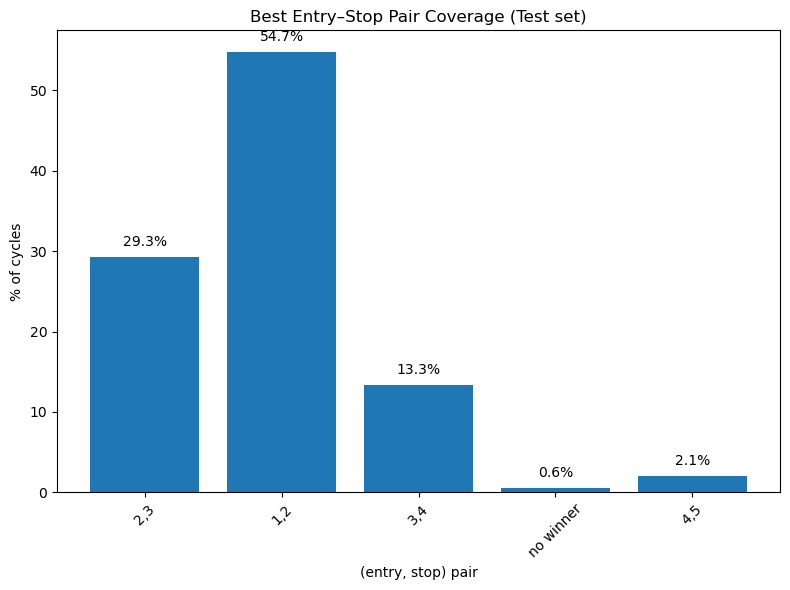

In [47]:
testing_best_pairs = env_test.best_pairs
testing_counts = Counter(testing_best_pairs)
# Convert raw counts to percentages
testing_pairs = list(testing_counts.keys())
testing_percentages = [testing_counts[p] / len(testing_best_pairs) * 100 for p in testing_pairs]
# Turn None → a string label
testing_labels = [
    "no winner" if p is None else f"{p[0]},{p[1]}"
    for p in testing_pairs
]
# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(range(len(testing_labels)), testing_percentages, tick_label=testing_labels)
plt.ylabel("% of cycles")
plt.xlabel("(entry, stop) pair")
# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.1f}%", ha='center', va='bottom')
plt.xticks(rotation=45)
plt.title("Best Entry–Stop Pair Coverage (Test set)")
plt.tight_layout()

# Save final results 
---

In [48]:
# #Create a dataframe to store the number of epochs, trials, best hyperparameters, best reward, training metrics and test metrics
# df_results = pd.DataFrame({
#     'num_epochs': [num_epochs],
#     'n_trials': [n_trials],
#     'best_hyperparameters': [best_params],
#     'best_validation_reward': [best_reward],
#     'training_metrics': [training_metrics],
#     'test_metrics': [test_metrics],
#     'final_return_test_set (%)': [final_return_test_set]
# })
  

In [49]:
# df_results.to_csv('results/reinforcement_learning/MANAUSDT_SANDUSDT_results.csv', header=False, mode='a', index=False)

In [50]:
# read_test = pd.read_csv('results/reinforcement_learning/MANAUSDT_SANDUSDT_results.csv', parse_dates=True)
# read_test